In [21]:
# loan_model_training.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [22]:
# 1. Load datasets
app_df = pd.read_csv("application_record.csv", on_bad_lines='skip')
credit_df = pd.read_csv("credit_record.csv", on_bad_lines='skip')

In [23]:
# 2. Merge datasets
merged_df = pd.merge(app_df, credit_df, on="ID")

In [24]:
# 3. Create binary target variable
merged_df["TARGET"] = merged_df["STATUS"].apply(lambda x: 0 if x in ["C", "0"] else 1)

In [25]:
# 4. Drop unneeded columns
merged_df.drop(["ID", "STATUS"], axis=1, inplace=True)

# ========== EDA Section ==========

In [26]:
print("\n=== Shape of Dataset ===")
print(merged_df.shape)

print("\n=== Dataset Info ===")
print(merged_df.info())

print("\n=== First 5 Rows ===")
print(merged_df.head())

print("\n=== Summary Statistics ===")
print(merged_df.describe())

print("\n=== Categorical Columns ===")
print(merged_df.select_dtypes(include=['object']).nunique())

print("\n=== Missing Values ===")
missing = merged_df.isnull().sum()
print(missing[missing > 0])


=== Shape of Dataset ===
(777715, 19)

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777715 entries, 0 to 777714
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   CODE_GENDER          777715 non-null  object 
 1   FLAG_OWN_CAR         777715 non-null  object 
 2   FLAG_OWN_REALTY      777715 non-null  object 
 3   CNT_CHILDREN         777715 non-null  int64  
 4   AMT_INCOME_TOTAL     777715 non-null  float64
 5   NAME_INCOME_TYPE     777715 non-null  object 
 6   NAME_EDUCATION_TYPE  777715 non-null  object 
 7   NAME_FAMILY_STATUS   777715 non-null  object 
 8   NAME_HOUSING_TYPE    777715 non-null  object 
 9   DAYS_BIRTH           777715 non-null  int64  
 10  DAYS_EMPLOYED        777715 non-null  int64  
 11  FLAG_MOBIL           777715 non-null  int64  
 12  FLAG_WORK_PHONE      777715 non-null  int64  
 13  FLAG_PHONE           777715 non-null  int64  
 14  FLAG_EM

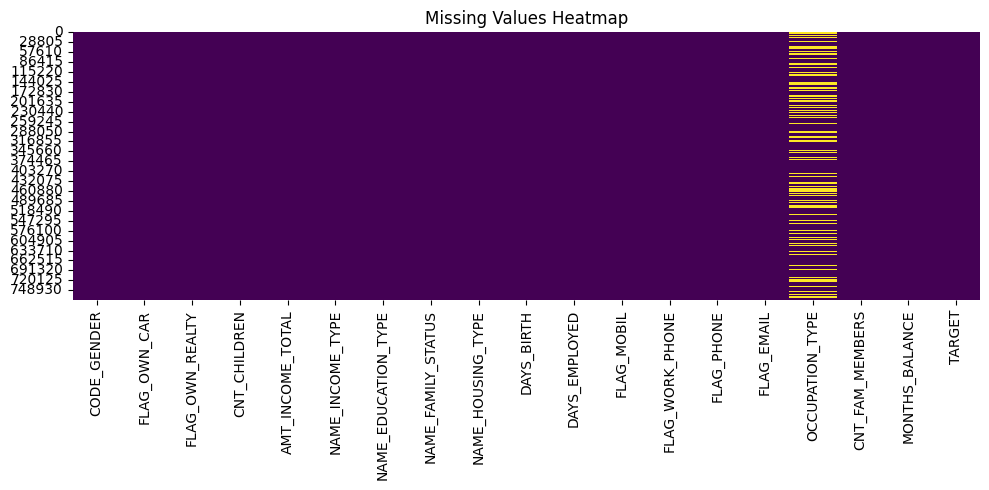

In [27]:
# Visualize missing values
plt.figure(figsize=(10, 5))
sns.heatmap(merged_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.tight_layout()
plt.savefig("missing_values_heatmap.png")
plt.show()

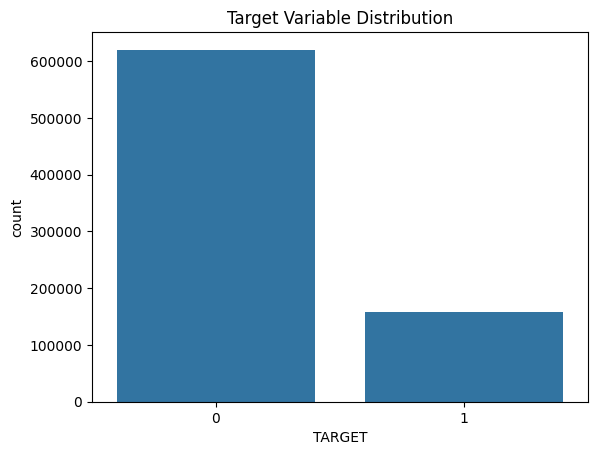

In [28]:
# Target variable distribution
sns.countplot(x="TARGET", data=merged_df)
plt.title("Target Variable Distribution")
plt.savefig("target_distribution.png")
plt.show()

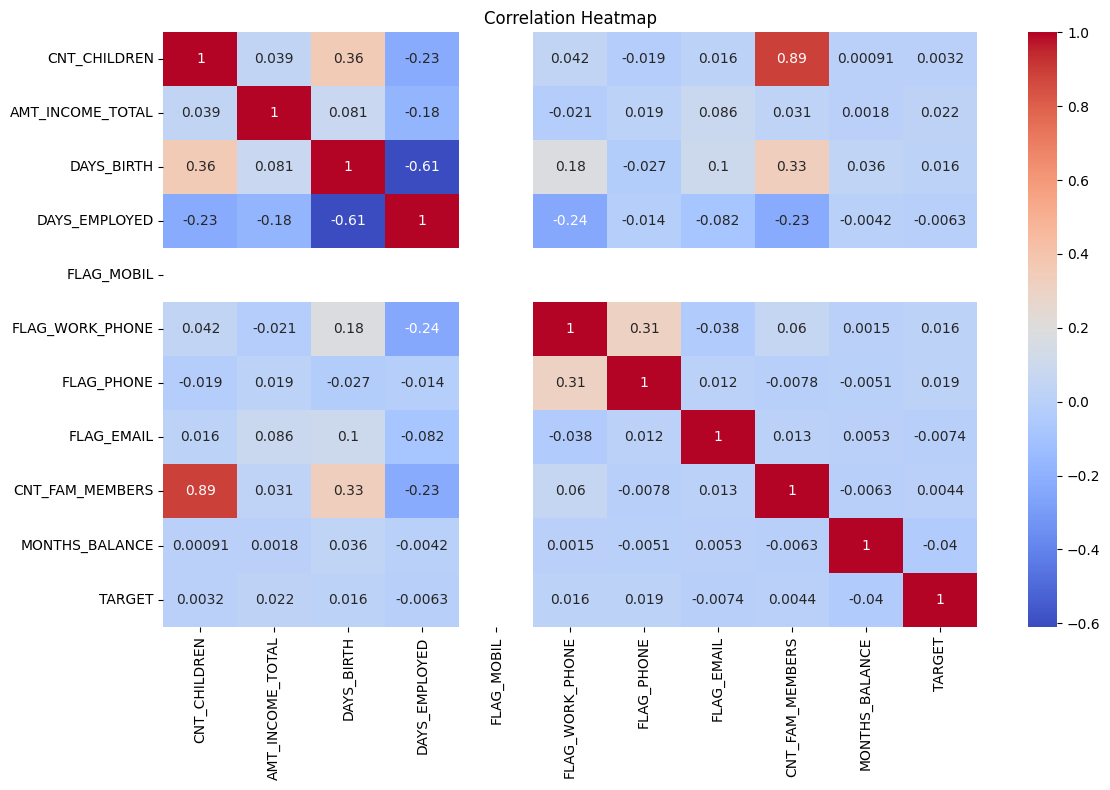

In [29]:
# Correlation heatmap (numeric columns only)
plt.figure(figsize=(12, 8))
numeric_cols = merged_df.select_dtypes(include=['number'])  # Select only numeric columns
sns.heatmap(numeric_cols.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

# ========== Preprocessing =========

In [30]:
# Fill missing values
merged_df.fillna(method='ffill', inplace=True)

C:\Users\Pc\AppData\Local\Temp\ipykernel_1888\1684964199.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [31]:
# Encode categorical features
label_encoders = {}
for col in merged_df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

In [32]:
# Split features and target
X = merged_df.drop("TARGET", axis=1)
y = merged_df["TARGET"]

In [33]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [34]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Handle imbalance with SMOTE
print("\nBefore SMOTE:")
print(y_train.value_counts())
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("\nAfter SMOTE:")
print(pd.Series(y_train).value_counts())


Before SMOTE:
TARGET
0    495961
1    126211
Name: count, dtype: int64

After SMOTE:
TARGET
0    495961
1    495961
Name: count, dtype: int64


In [36]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
# Evaluation
print("\nClassification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    124229
           1       0.49      0.53      0.51     31314

    accuracy                           0.79    155543
   macro avg       0.68      0.70      0.69    155543
weighted avg       0.80      0.79      0.80    155543


Confusion Matrix:
[[106681  17548]
 [ 14612  16702]]


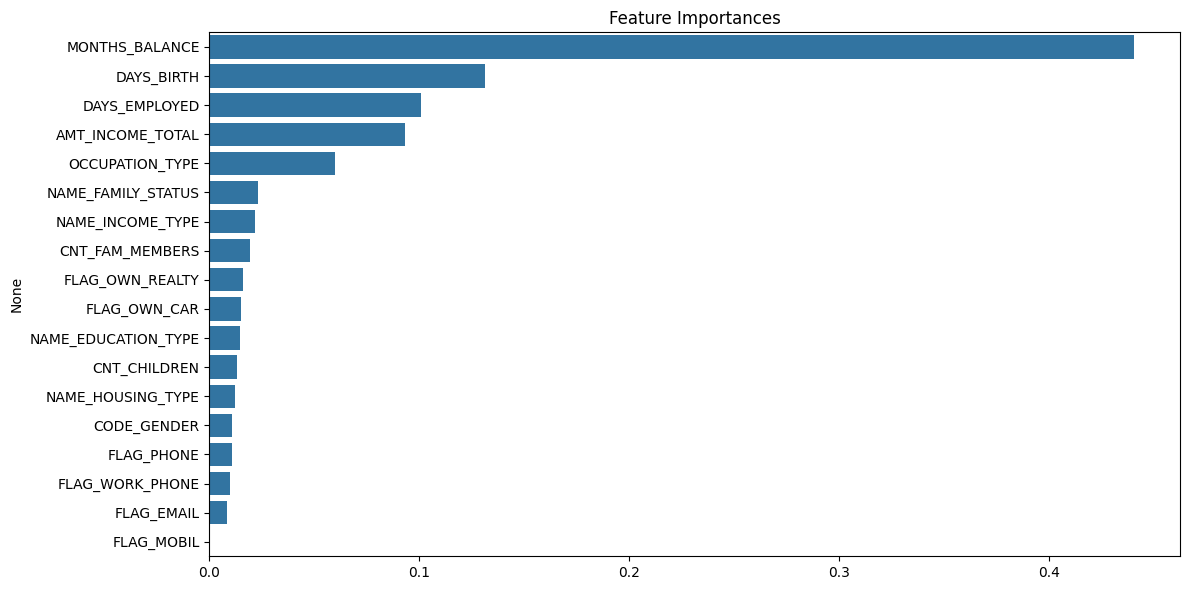

In [38]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [39]:
# Save model
model_bundle = {
    "model": model,
    "feature_names": X.columns.tolist(),
    "scaler": scaler,
    "label_encoders": label_encoders
}

with open("model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

print("\n✅ Model training complete. 'model.pkl' saved.")


✅ Model training complete. 'model.pkl' saved.
